# Assignment 3: Recurrent Neural Network (RNN) {-}

This assignment aims at familiarizing you with training and testing the RNN neural network for an image classification task. You will go through the process of loading data, preprocessing images, building the RNN model, and evaluating its performance.

The assignment rqeuirements include:
- **3.1 (1 point)** Load the dataset.
- **3.2 (1 point)** Analyze and process the dataset.
- **3.3 (2 points)** Construct an RNN model using GRU (Gated Recurrent Unit) instead of LSTM, as demonstrated in the demo code (https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU). Train and evaluate the model’s performance on the test set.
- **3.4 (2 points)** Construct an RNN model using Bidirectional LSTM (BiLSTM, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Train and evaluate the model’s performance on the test set.
- **3.5 (2 points)** Construct an RNN model using Bidirectional GRU (BiGRU, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Train and evaluate the model’s performance on the test set.
- **3.6 (2 points)** Compare the accuracy and runtime efficiency among LSTM, GRU, BiLSTM, and BiGRU models. Provide comments and observations on the performance of each model variant.

The dataset you will be working on is imdb_reviews. This dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a positive or negative sentiment. Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
- label (tf.int64)
- text (tf.string)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment3-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named DL4AI-\<StudentID>-Assignment3 (e.g., DL4AI-2012345-Assigment3) and then compressed with the same name.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. The model accuracy on the test set is one of the most important evaluation criteria. Therefore try to push it as high as possible. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

# Download tensorflow datasets
!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.O3WBOO_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.O3WBOO_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.O3WBOO_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [3]:
# Show same samples in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [4]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = tf.convert_to_tensor(list(map(lambda x: x[0], train_numpy)), dtype=tf.string) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = tf.convert_to_tensor(list(map(lambda x: x[0], val_numpy)), dtype=tf.string) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset)  # Convert TF Dataset to an iterable of numpy arrays
test_numpy = np.vstack(list(test_ds_numpy))  # Stack to full numpy array
X_test = tf.convert_to_tensor(list(map(lambda x: x[0], test_numpy)), dtype=tf.string)  # Extract reviews (index 0)
y_test = np.array(list(map(lambda x: x[1], test_numpy)), dtype=np.int32)  # Extract labels (index 1), convert to int32
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


In [5]:
### TextVectorization layer maps text features to integer sequences.
# Set vocabulary size for the training data
VOCAB_SIZE = 1000

# Initialize the TextVectorization layer for raw text encoding
text_encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Maximum size of the vocabulary

# Feed training text to adapt() method to calculate the layer's vocabulary
text_encoder.adapt(X_train)

In [6]:
# Show the first 20 tokens. After the padding ('') and unknown ([UNK]) tokens they're sorted by frequency.
vocab = np.array(text_encoder.get_vocabulary()) # Get the vocabulary of the training set after the adaptation
print("Vocabulary size:", vocab.shape)
vocab[:20] # Show the first 20 tokens (sorted by frequency) in the vocabulary

Vocabulary size: (1000,)


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:

# Create the model that uses the text vectorization layer
model_encoder = tf.keras.models.Sequential()

# Creating an explicit input layer.
# It needs to have a shape of (1,) (because we need to guarantee that there is exactly one string input per batch),
model_encoder.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first (unique) layer in the model is the vectorization layer.
# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.
model_encoder.add(text_encoder)

# The model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.
test_data = [["I want to drink"], ["I do not want to eat but I want to sleep"]]
test_data = tf.convert_to_tensor(test_data, dtype=tf.string)
model_encoder.predict(test_data)

# Note: The tensors of indices are zero-padded to the longest sequence in the batch,
# to make sure that all tensors of indices have the same size (for batching purpose).

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[ 10, 179,   6,   1,   0,   0,   0,   0,   0,   0,   0],
       [ 10,  79,  22, 179,   6,   1,  19,  10, 179,   6,   1]])

In [8]:
# Note: the vectorization process is not completely reversible due to the limited vocabulary size
print("Original: ", X_train[0])
print()
print("Round-trip: ", " ".join(vocab[text_encoder(X_train[0]).numpy()]))

Original:  tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)

Round-trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous sto

In [9]:
# Test TextVectorization layer manually
sample_text = ["This is a test sentence.", "Another review."]
encoded_text = text_encoder(np.array(sample_text))
print("Encoded text:", encoded_text)


Encoded text: tf.Tensor(
[[ 11   7   4   1   1]
 [154 735   0   0   0]], shape=(2, 5), dtype=int64)


In [10]:
# Reshape X_train and X_val to (num_samples, 1) using tf.reshape
X_train = tf.reshape(X_train, (-1, 1))
X_val = tf.reshape(X_val, (-1, 1))

# Verify the shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")


Shape of X_train: (20000, 1)
Shape of X_val: (5000, 1)


# RGU

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,), dtype=tf.string),  # Specify the input shape for raw text
    text_encoder,  # TextVectorization layer to map text to integers
    tf.keras.layers.Embedding(  # Embedding layer to convert integer indices to dense vectors
        input_dim=len(text_encoder.get_vocabulary()),  # Vocabulary size (from text_encoder)
        output_dim=64,  # Output embedding dimension
        mask_zero=True   # Mask zero padding in sequences
    ),
    tf.keras.layers.GRU(units=64),  # GRU layer to capture sequential dependencies
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer with ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification (positive/negative sentiment)
])

# Print the model summary to inspect the parameters
model.summary()
print([layer.supports_masking for layer in model.layers])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 64)            │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,185 (364.00 KB)

 Trainable params: 93,185 (364.00 KB)

 Non-trainable params: 0 (0.00 B)

[False, True, True, True, True]


In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_val, y_val))


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5351 - loss: 0.6894 - val_accuracy: 0.6600 - val_loss: 1.1766
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5928 - loss: 0.7308 - val_accuracy: 0.7128 - val_loss: 0.5820
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7415 - loss: 0.5379 - val_accuracy: 0.7312 - val_loss: 0.5200
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.7902 - loss: 0.4517 - val_accuracy: 0.7726 - val_loss: 0.4654
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8415 - loss: 0.3734 - val_accuracy: 0.8460 - val_loss: 0.3547


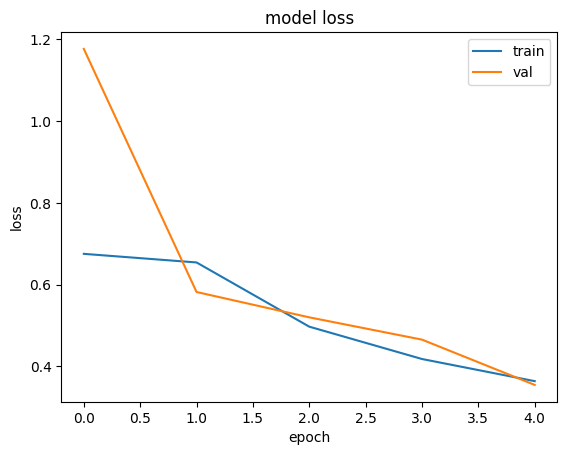

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

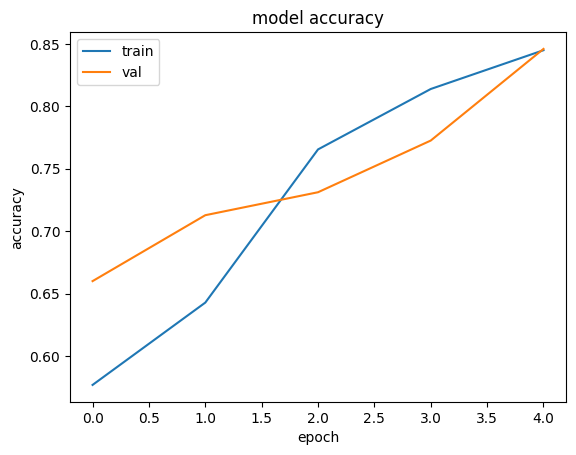

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Reshape X_test to (num_samples, 1)
X_test = tf.reshape(X_test, (-1, 1))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8555 - loss: 0.3432
Test Loss: 0.34404417872428894
Test Accuracy: 0.8526399731636047


In [ ]:
# Sample reviews for prediction
sample_reviews = [
    'It is a cool movie. The graphics and the animation are awesome.',
    'The movie was really bad. I would not recommend it to anyone.'
]

# Convert sample_reviews to a tensor with dtype=tf.string
sample_reviews_tensor = tf.convert_to_tensor(sample_reviews, dtype=tf.string)

# Reshape the tensor to make it (batch_size, 1), where batch_size = len(sample_reviews)
# This makes each review be treated as a sequence of strings (even if each review is one sequence)
sample_reviews_tensor = tf.reshape(sample_reviews_tensor, (-1, 1))

# Make predictions
predictions = model.predict(sample_reviews_tensor)

# Print the predictions for each review
print(predictions[0])  # Prediction for the first review
print(predictions[1])  # Prediction for the second review


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[0.7710652]
[0.29951185]


# Bidirectional Long Short Term Memory

In [ ]:
# Define the model architecture with BiLSTM (Bidirectional LSTM)
model_bilstm = tf.keras.Sequential([
    tf.keras.Input(shape=(None,), dtype=tf.string),  # Specify the input shape for raw text
    text_encoder,  # TextVectorization layer to map text to integers
    tf.keras.layers.Embedding(  # Embedding layer to convert integer indices to dense vectors
        input_dim=len(text_encoder.get_vocabulary()),  # Vocabulary size (from text_encoder)
        output_dim=64,  # Output embedding dimension
        mask_zero=True   # Mask zero padding in sequences
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),  # BiLSTM layer to capture sequential dependencies
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer with ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Print the model summary to inspect the parameters
model_bilstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 64)            │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,369 (540.50 KB)

 Trainable params: 138,369 (540.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_bilstm.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['accuracy'])

# Train the model
history = model_bilstm.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_val, y_val))


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.5673 - loss: 0.6758 - val_accuracy: 0.8254 - val_loss: 0.4160
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.8086 - loss: 0.4262 - val_accuracy: 0.8488 - val_loss: 0.3557
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.8439 - loss: 0.3608 - val_accuracy: 0.8474 - val_loss: 0.3605
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8565 - loss: 0.3342 - val_accuracy: 0.8532 - val_loss: 0.3466
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8647 - loss: 0.3224 - val_accuracy: 0.8564 - val_loss: 0.3380


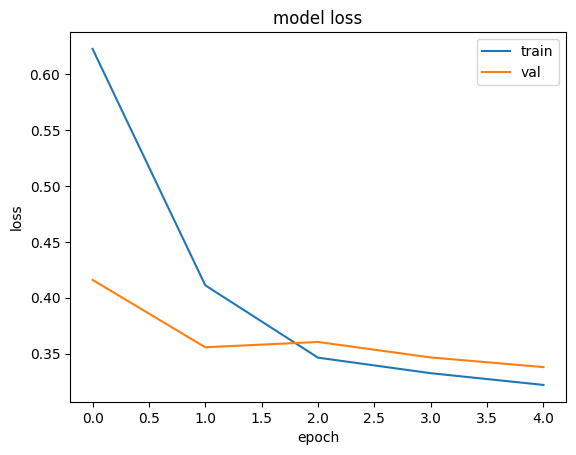

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

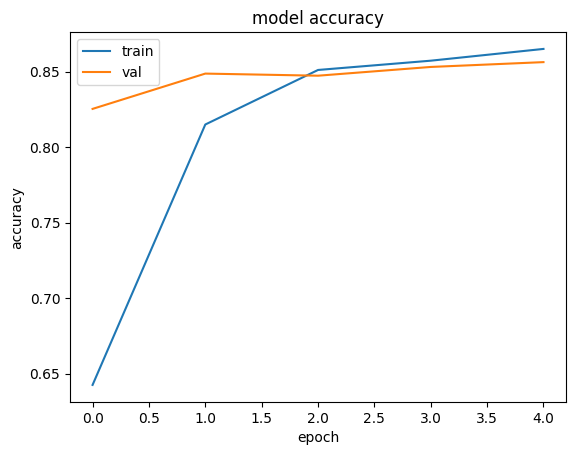

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Reshape X_test to (num_samples, 1)
X_test = tf.reshape(X_test, (-1, 1))

# Evaluate the model on the test set
test_loss, test_acc = model_bilstm.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8556 - loss: 0.3327
Test Loss: 0.3319065570831299
Test Accuracy: 0.8558400273323059


# Bi GRU

In [11]:
# Define the model architecture with BiGRU (Bidirectional GRU)
model_bigru = tf.keras.Sequential([
    tf.keras.Input(shape=(None,), dtype=tf.string),  # Specify the input shape for raw text
    text_encoder,  # TextVectorization layer to map text to integers
    tf.keras.layers.Embedding(  # Embedding layer to convert integer indices to dense vectors
        input_dim=len(text_encoder.get_vocabulary()),  # Vocabulary size (from text_encoder)
        output_dim=64,  # Output embedding dimension
        mask_zero=True   # Mask zero padding in sequences
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=64)),  # BiGRU layer to capture sequential dependencies
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer with ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Print the model summary to inspect the parameters
model_bigru.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 64)            │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,241 (477.50 KB)

 Trainable params: 122,241 (477.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
model_bigru.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['accuracy'])

# Train the model
history = model_bigru.fit(X_train, y_train, epochs=4, batch_size=256, validation_data=(X_val, y_val))


Epoch 1/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.5453 - loss: 0.6888 - val_accuracy: 0.7454 - val_loss: 0.5864
Epoch 2/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.7652 - loss: 0.4871 - val_accuracy: 0.8384 - val_loss: 0.3572
Epoch 3/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.8354 - loss: 0.3660 - val_accuracy: 0.8572 - val_loss: 0.3336
Epoch 4/4
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8633 - loss: 0.3212 - val_accuracy: 0.8602 - val_loss: 0.3314


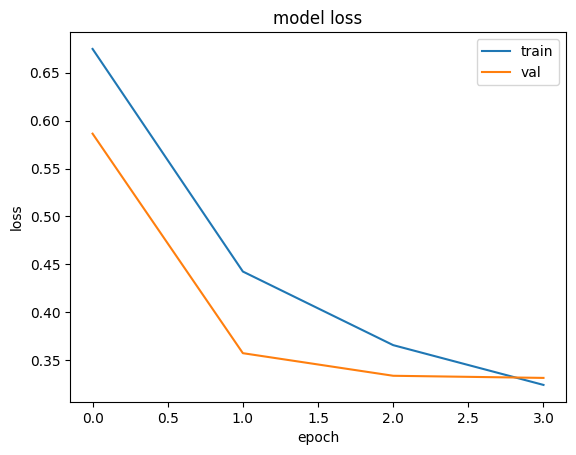

In [13]:
# Visualize the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

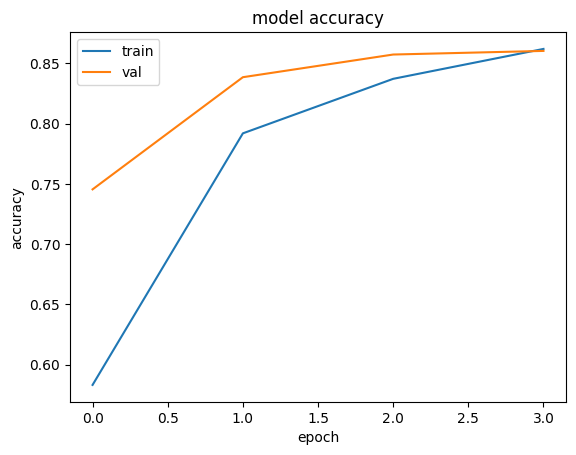

In [14]:
# Visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# Reshape X_test to (num_samples, 1)
X_test = tf.reshape(X_test, (-1, 1))

# Evaluate the model on the test set
test_loss, test_acc = model_bigru.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8592 - loss: 0.3292
Test Loss: 0.3276771008968353
Test Accuracy: 0.8582000136375427


# Compare the accuracy and runtime efficiency among LSTM, GRU, BiLSTM, and BiGRU models. Provide comments and observations on the performance of each model variant.

**Test Results Summary**

**GRU:**

*   Test Loss: 0.3440
*   Test Accuracy: 85.26%



**BiLSTM:**



*   Test Loss: 0.3319
*   Test Accuracy: 85.58%



**BiGRU:**


*   Test Loss: 0.3277
*   Test Accuracy: 85.82%


Among these models, BiGRU achieves the best performance in terms of test accuracy and loss.

**GRU Performance**

GRU exhibited good convergence, with steadily decreasing loss and increasing accuracy.
However, there were slight signs of potential overfitting or divergence during training (e.g., validation metrics plateauing while training metrics continued to improve).
Being a unidirectional model, GRU might be slightly less effective in generalization compared to the bidirectional models.

**BiLSTM Performance**

BiLSTM displayed strong convergence, with training and validation metrics closely aligned, reflecting good generalization to unseen data.
The model required more epochs (4-5) to reach optimal performance, but the results were stable and reliable.
Test performance closely matched the validation metrics, further highlighting its strong generalization ability.
While BiLSTM is a strong contender, it has higher computational costs compared to GRU due to the bidirectional LSTM architecture.


**BiGRU Performance**

BiGRU showed rapid convergence, achieving good performance in just 3 epochs, making it efficient in terms of runtime.
Slightly higher validation accuracy compared to training accuracy indicates robust generalization without overfitting.
With a test accuracy of 85.82%, BiGRU generalizes well and outperforms BiLSTM while being computationally simpler and faster to train.









